## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2


### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [68]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

fatal: destination path 'imagenet10' already exists and is not an empty directory.


Check that the repository is there:

In [69]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [73]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/canoe/n02951358_11179.JPEG,2
1,imagenet10/train_set/banana/n07753592_9210.JPEG,1
2,imagenet10/train_set/football/n04254680_7755.JPEG,7
3,imagenet10/train_set/mug/n03797390_5222.JPEG,8
4,imagenet10/train_set/banana/n07753592_2590.JPEG,1


Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [76]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [01:05<00:00, 137.19it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
train_split = 0.80 #improving network performance
#train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

You will need to create DataLoaders for the datasets.

In [79]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=16, # use 10, Forward pass only so batch size can be larger
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = np.arange(0, 10)

# 24 images at a time
for i, data in enumerate(test_loader, 0):
    images, labels = data
    print("Batch", i, "size:", len(images))
    
    # Do stuff with the images and labels.
    break # Terrible programming. Just for illustration.

Batch 0 size: 24


In [80]:
len(test_loader)

38

In [0]:
extra_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=1,
    shuffle=False,
)

iterator = iter(extra_loader)

In [21]:
iterator.next()

[tensor([[[[-1.5586, -1.5586, -1.5454,  ..., -0.9132, -0.3336, -0.5443],
           [-1.5586, -1.5586, -1.5454,  ..., -0.9395, -0.6365, -0.6629],
           [-1.5586, -1.5454, -1.5454,  ..., -0.7419, -0.7287, -0.6365],
           ...,
           [-0.1228, -0.2677, -0.3863,  ...,  0.2724,  0.2197,  0.2065],
           [-0.3336, -0.4126, -0.4916,  ...,  0.1143,  0.1143,  0.1143],
           [-0.4653, -0.4916, -0.6629,  ..., -0.1228, -0.0569, -0.0306]],
 
          [[-1.4442, -1.4442, -1.4442,  ..., -0.5888,  0.0493, -0.1544],
           [-1.4442, -1.4306, -1.4442,  ..., -0.6567, -0.3037, -0.2766],
           [-1.4442, -1.4442, -1.4442,  ..., -0.4395, -0.3988, -0.2901],
           ...,
           [-0.2901, -0.4531, -0.6024,  ...,  0.1172, -0.0729, -0.0593],
           [-0.4802, -0.5481, -0.6974,  ..., -0.1001, -0.1679, -0.1408],
           [-0.6024, -0.6567, -0.8061,  ..., -0.4123, -0.3716, -0.3852]],
 
          [[-1.0759, -1.0885, -1.1263,  ..., -0.3087,  0.1944,  0.0561],
           [-

A framework for the ConvNet model, missing all layers except the final fully-connected layer:

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size = 4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size = 4)

        # Linear layers
        self.fc1 = nn.Linear(26912, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Complete the graph
        #input layer
        x = x
        
        # hidden conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden linear layer
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)

        # hidden linear layer
        x = self.fc2(x)
      
        return x
        

In [98]:
# Device configuration - defaults to CPU unless GPU is available on device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Put the model on GPU

In [0]:
model_gpu = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent
optimizer = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)
train_losses = []
valid_losses = []

Put data on the GPU

In [0]:
def train_model_epochs2(num_epochs):
    """ Copy of function train_model_epochs but explicitly copying data to device 
        during training. 
    """
    for epoch in range(num_epochs):

        #running_loss = 0.0
        train_loss = 0.0
        valid_loss = 0.0

        model_gpu.train()

        for i, data in enumerate(train_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            #running_loss += loss.item()
            train_loss += loss.item() * images.size(0)
            
            #if i % 100 == 99:    # print every 100 mini-batches
                #print('Epoch / Batch [%d / %d] - Loss: %.3f' %
                      #(epoch + 1, i + 1, running_loss / 1000))
                #running_loss = 0.0

        model_gpu.eval()
        for i, data in enumerate(valid_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            #calculate batch loss
            loss = criterion(outputs, labels)

            #update total valid loss
            valid_loss += loss.item() * images.size(0)


        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        train_losses.append(train_loss/1000)
        valid_losses.append(valid_loss/1000)

        print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f}'.format(
                epoch + 1, train_loss, valid_loss))


            


Train an identical model on GPU

In [0]:
import timeit

In [102]:
gpu_train_time = timeit.timeit(
    "train_model_epochs2(num_epochs)",
    setup="num_epochs=10",
    number=1,
    globals=globals(),
 )

Epoch: 1 	Train Loss: 1.972072 	Valid Loss: 1.862577
Epoch: 2 	Train Loss: 1.731040 	Valid Loss: 1.666585
Epoch: 3 	Train Loss: 1.585425 	Valid Loss: 1.485423
Epoch: 4 	Train Loss: 1.441690 	Valid Loss: 1.500187
Epoch: 5 	Train Loss: 1.333350 	Valid Loss: 1.480844
Epoch: 6 	Train Loss: 1.210232 	Valid Loss: 1.349694
Epoch: 7 	Train Loss: 1.110040 	Valid Loss: 1.367898
Epoch: 8 	Train Loss: 0.991359 	Valid Loss: 1.347418
Epoch: 9 	Train Loss: 0.876645 	Valid Loss: 1.440476
Epoch: 10 	Train Loss: 0.761876 	Valid Loss: 1.509604


GPU train time

In [103]:
gpu_train_time

568.5238660020004

Performance on Test Set

In [104]:
correct = 0
total = 0

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        
        # copy data on device
        images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
        labels = labels.to(device)  # <----------- variables still exist on CPU
        
        outputs = model_gpu(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 52 %


# **Experiment** **1**

Number of Layers. Using 2, 3, 5 layers 


# **2 Layer Neural Network**

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size = 4)
       #self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size = 4)
       #self.conv4 = nn.Conv2d(in_channels=40, out_channels=48, kernel_size = 4)
       #self.conv5 = nn.Conv2d(in_channels=56, out_channels=64, kernel_size = 4)

        # Linear layers
        self.fc1 = nn.Linear(92256, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Complete the graph
        #input layer
        x = x
        
        # hidden conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 3
        #x = self.conv3(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, kernel_size = 2)
        #x = F.dropout(x, p=0.3)

        # hidden linear layer
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)

        # hidden linear layer
        x = self.fc2(x)
      
        return x

# **4 Layer Neural Network**

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size = 4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size = 4)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=40, kernel_size = 4)
       #self.conv5 = nn.Conv2d(in_channels=40, out_channels=48, kernel_size = 4)

        # Linear layers
        self.fc1 = nn.Linear(6760, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Complete the graph
        #input layer
        x = x
        
        # hidden conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 4
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)


        # hidden linear layer
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)

        # hidden linear layer
        x = self.fc2(x)
      
        return x

# **5 Layer neural network**

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size = 4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size = 4)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=40, kernel_size = 4)
        self.conv5 = nn.Conv2d(in_channels=40, out_channels=48, kernel_size = 4)

        # Linear layers
        self.fc1 = nn.Linear(1200, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Complete the graph
        #input layer
        x = x
        
        # hidden conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 4
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 5
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.dropout(x, p=0.3)


        # hidden linear layer
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)

        # hidden linear layer
        x = self.fc2(x)
      
        return x

# **Experiment 2**

## **Max-Pool Kernel Size = 3, 4**

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size = 4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size = 4)

        # Linear layers
        self.fc1 = nn.Linear(2048, 512) #kernel size = 3
        #self.fc1 = nn.Linear(288, 512) # kernel size = 4
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Complete the graph
        #input layer
        x = x
        
        # hidden conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3)
        #x = F.max_pool2d(x, kernel_size=4)

        x = F.dropout(x, p=0.3)

        # hidden conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 3)
        #x = F.max_pool2d(x, kernel_size=4)

        x = F.dropout(x, p=0.3)

        # hidden conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 3)
        #x = F.max_pool2d(x, kernel_size=4)

        x = F.dropout(x, p=0.3)

        # hidden linear layer
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)

        # hidden linear layer
        x = self.fc2(x)
      
        return x

In [443]:
# Device configuration - defaults to CPU unless GPU is available on device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
model_gpu = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent
optimizer = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

train_losses = []
valid_losses = []

# **Filter Visualization for the best performing network, 4 layers**

In [0]:
def filter_visualization(channel):
   
   filters = channel.weight.data
   filters = filters.cpu()
   filters = filters.numpy()
   filters = (filters - np.min(filters))/(np.max(filters) - np.min(filters))
   fig = plt.figure(figsize=(22,5))
   i = 1
   for filter in filters:
    for channel in filter:
      plt.subplot(3, 16, i)
      plt.imshow(channel, cmap="gray")
      plt.axis('off')
      i=i+1

      fig.show


# **Filter visualization before training**

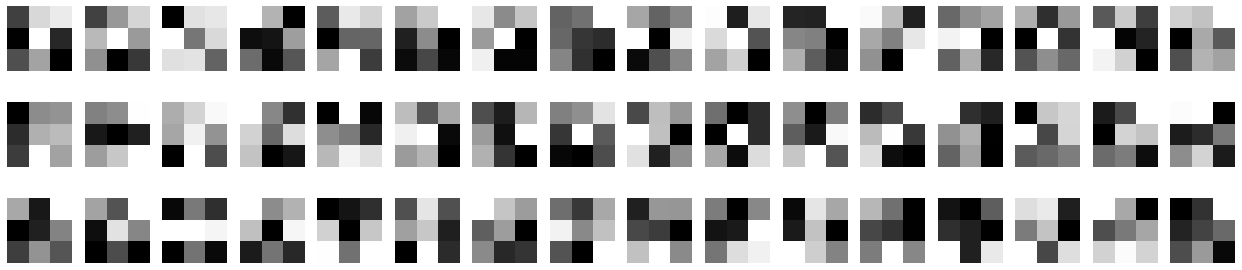

In [363]:
filter_visualization(model_gpu.conv1)

# **Training on GPU**

In [0]:
def train_model_epochs2(num_epochs):
    """ Copy of function train_model_epochs but explicitly copying data to device 
        during training. 
    """
    for epoch in range(num_epochs):
          
          #filter visualization halfway during training
        if epoch == (num_epochs/2):
          filter_visualization(model_gpu.conv1)


        #running_loss = 0.0
        train_loss = 0.0
        valid_loss = 0.0

        model_gpu.train()

        for i, data in enumerate(train_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            #running_loss += loss.item()
            train_loss += loss.item() * images.size(0)
            
            #if i % 100 == 99:    # print every 100 mini-batches
                #print('Epoch / Batch [%d / %d] - Loss: %.3f' %
                      #(epoch + 1, i + 1, running_loss / 1000))
                #running_loss = 0.0

        model_gpu.eval()
        for i, data in enumerate(valid_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            #calculate batch loss
            loss = criterion(outputs, labels)

            #update total valid loss
            valid_loss += loss.item() * images.size(0)


        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        train_losses.append(train_loss/1000)
        valid_losses.append(valid_loss/1000)

        print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f}'.format(
                epoch + 1, train_loss, valid_loss))


Timing of GPU training

In [0]:
import timeit

Epoch: 1 	Train Loss: 2.152492 	Valid Loss: 1.961857
Epoch: 2 	Train Loss: 1.865015 	Valid Loss: 1.807412
Epoch: 3 	Train Loss: 1.752385 	Valid Loss: 1.732475
Epoch: 4 	Train Loss: 1.691364 	Valid Loss: 1.722777
Epoch: 5 	Train Loss: 1.631914 	Valid Loss: 1.661882
Epoch: 6 	Train Loss: 1.553194 	Valid Loss: 1.586564
Epoch: 7 	Train Loss: 1.481684 	Valid Loss: 1.649058
Epoch: 8 	Train Loss: 1.421395 	Valid Loss: 1.479772
Epoch: 9 	Train Loss: 1.337541 	Valid Loss: 1.410749
Epoch: 10 	Train Loss: 1.249756 	Valid Loss: 1.426599


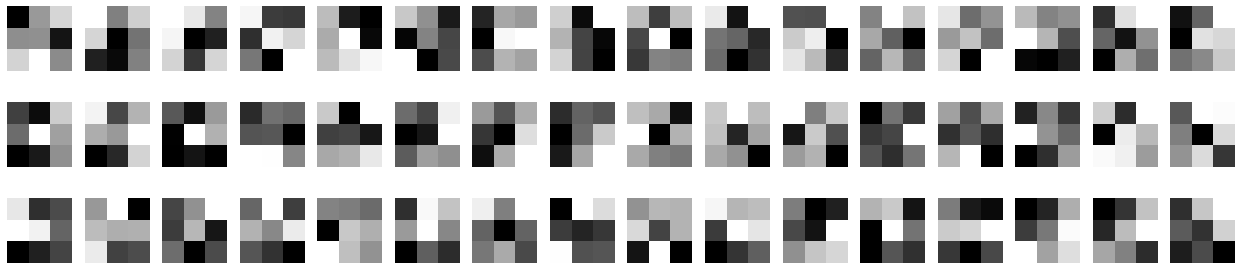

In [446]:
gpu_train_time = timeit.timeit(
    "train_model_epochs2(num_epochs)",
    setup="num_epochs=10",
    number=1,
    globals=globals(),
 )

In [434]:
gpu_train_time

504.68616619399836

# **Filter visualization after training**

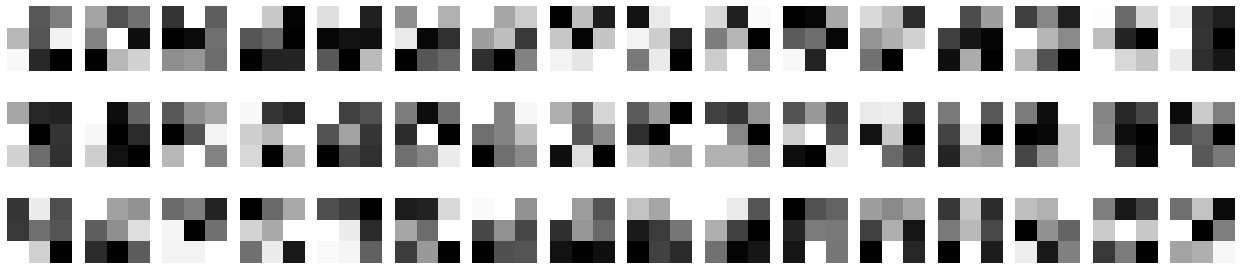

In [350]:
filter_visualization(model_gpu.conv1)


# **Performance of classifier on Test Set**

In [447]:
correct = 0
total = 0

total_predictions = torch.tensor([])
total_predictions = total_predictions.to(device)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        
        # copy data on device
        images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
        labels = labels.to(device)  # <----------- variables still exist on CPU
        
        outputs = model_gpu(images)
        total_predictions = torch.cat(
            (total_predictions,outputs),dim=0
        )

        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 51 %


# **Training loss vs validation loss**

Text(0.5, 1.0, 'training loss vs validation loss')

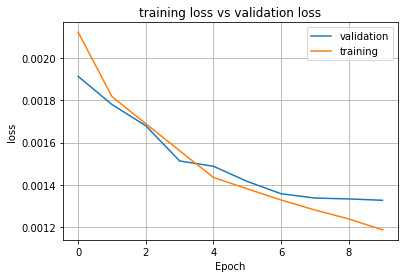

In [436]:
val_line, = plt.plot(valid_losses, label='validation')
train_line, =plt.plot(train_losses, label='training')
plt.legend(handles=[val_line, train_line])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.title("training loss vs validation loss")


In [437]:
total_predictions = total_predictions.cpu()
total_predictions.argmax(dim=1).shape

torch.Size([1800])

In [438]:
total_labels = torch.tensor(ins_dataset_test.df['class'])
total_labels.shape

torch.Size([1800])

**Accuracy and Confusion matrix**

In [439]:
cm = confusion_matrix(total_labels, total_predictions.argmax(dim=1))
cm

array([[113,   1,   4,  25,   0,   0,   0,   3,   2,   1],
       [  5,  95,   7,   8,   5,   0,   0,   5,   7,  57],
       [ 11,   5, 139,   6,  16,   2,   4,   1,   5,   2],
       [ 36,   3,   3,  97,   2,   1,   0,   5,   5,   6],
       [  0,   2,  15,   0, 127,   3,   2,   1,  26,  10],
       [  8,   8,   4,   6,  27,  77,  15,   6,  24,  13],
       [ 12,   9,   5,  13,  32,  18,  39,  11,  39,  12],
       [ 30,  10,  11,  26,  13,   6,   6,  59,  16,   4],
       [  8,  10,   7,   9,  14,   5,   5,   8, 109,  17],
       [  1,  16,   1,   1,   1,   1,   1,   3,   2, 149]])

**Easy viewing**

In [0]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


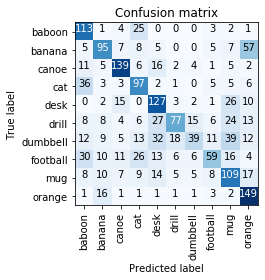

In [441]:
plot_confusion_matrix(cm, class_names)

# **Feature Map Visualization**

In [0]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [475]:
activations = []
for i in range(4):
  activations.append(SaveFeatures(list(model_gpu.children())[i]))

extra_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=1,
    shuffle=True,
)

iterator = iter(extra_loader)
first_img_batch, label1 = iterator.next()
second_img_batch, label2 = iterator.next()
model_gpu.cpu()

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

## **First image**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


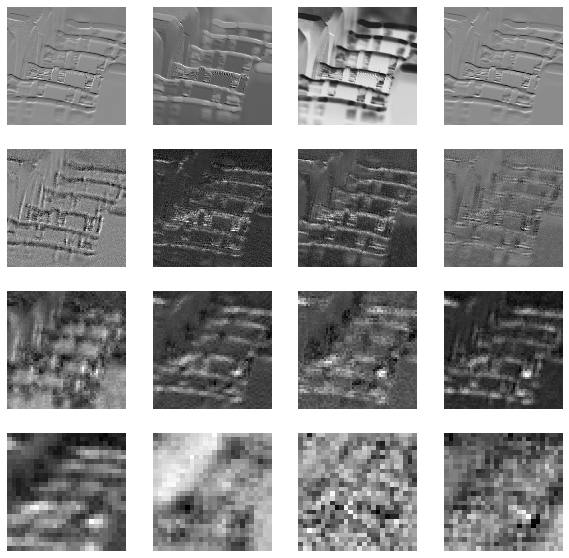

In [476]:
#For first image
model_gpu(first_img_batch)

for layer in model_gpu.children():
  for activation in activations:
    for feature in activation.features[0]:
      loss =- feature.mean()
      optimizer = optim.SGD([first_img_batch], lr=0.001, weight_decay=1e-6)
      optimizer.zero_grad()
      optimizer.step()

j = 1
fig = plt.figure(figsize=(10,10))
for activation in activations:
  for i in range(4):
    feature = activation.features[0, i].cpu().detach()

    plt.subplot(4, 4, j)
    plt.imshow(feature, cmap='gray')
    plt.axis('off')
    j = j + 1

fig.show()

## **Second image**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


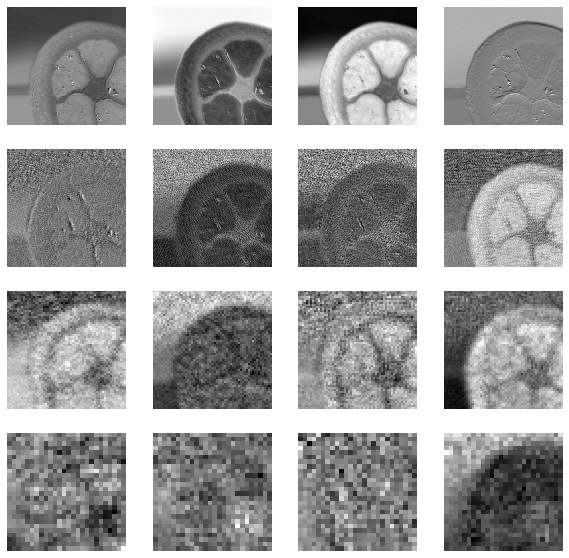

In [477]:
#For second image
model_gpu(second_img_batch)

for layer in model_gpu.children():
  for activation in activations:
    for feature in activation.features[0]:
      loss =- feature.mean()
      optimizer = optim.SGD([second_img_batch], lr=0.001, weight_decay=1e-6)
      optimizer.zero_grad()
      optimizer.step()

j = 1
fig = plt.figure(figsize=(10,10))
for activation in activations:
  for i in range(4):
    feature = activation.features[0, i].cpu().detach()

    plt.subplot(4, 4, j)
    plt.imshow(feature, cmap='gray')
    plt.axis('off')
    j = j + 1

fig.show()

# **Improving Network Performance**

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size = 4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size = 4)

        # Linear layers
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Complete the graph
        #input layer
        x = x
        
        # hidden conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 3)
        x = F.dropout(x, p=0.3)

        # hidden conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 3)
        x = F.dropout(x, p=0.3)

        # hidden linear layer
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)

        # hidden linear layer
        x = self.fc2(x)
      
        return x
        

In [82]:
# Device configuration - defaults to CPU unless GPU is available on device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
model_gpu = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent
optimizer = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

train_losses = []
valid_losses = []

Train on gpu

In [0]:
def train_model_epochs2(num_epochs):
    """ Copy of function train_model_epochs but explicitly copying data to device 
        during training. 
    """
    for epoch in range(num_epochs):
          
          #filter visualization halfway during training
       # if epoch == (num_epochs/2):
         # filter_visualization(model_gpu.conv1)


        #running_loss = 0.0
        train_loss = 0.0
        valid_loss = 0.0

        model_gpu.train()

        for i, data in enumerate(train_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            #running_loss += loss.item()
            train_loss += loss.item() * images.size(0)
            
            #if i % 100 == 99:    # print every 100 mini-batches
                #print('Epoch / Batch [%d / %d] - Loss: %.3f' %
                      #(epoch + 1, i + 1, running_loss / 1000))
                #running_loss = 0.0

        model_gpu.eval()
        for i, data in enumerate(valid_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            #calculate batch loss
            loss = criterion(outputs, labels)

            #update total valid loss
            valid_loss += loss.item() * images.size(0)


        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        train_losses.append(train_loss/1000)
        valid_losses.append(valid_loss/1000)

        print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f}'.format(
                epoch + 1, train_loss, valid_loss))


In [0]:
import timeit

time and training

In [87]:
gpu_train_time = timeit.timeit(
    "train_model_epochs2(num_epochs)",
    setup="num_epochs=30",
    number=1,
    globals=globals(),
 )

Epoch: 1 	Train Loss: 1.543878 	Valid Loss: 1.488766
Epoch: 2 	Train Loss: 1.457694 	Valid Loss: 1.416387
Epoch: 3 	Train Loss: 1.374547 	Valid Loss: 1.345091
Epoch: 4 	Train Loss: 1.295344 	Valid Loss: 1.320759
Epoch: 5 	Train Loss: 1.244019 	Valid Loss: 1.233255
Epoch: 6 	Train Loss: 1.190524 	Valid Loss: 1.372972
Epoch: 7 	Train Loss: 1.153242 	Valid Loss: 1.215054
Epoch: 8 	Train Loss: 1.109480 	Valid Loss: 1.211295
Epoch: 9 	Train Loss: 1.082331 	Valid Loss: 1.216531
Epoch: 10 	Train Loss: 1.048540 	Valid Loss: 1.181185
Epoch: 11 	Train Loss: 1.011414 	Valid Loss: 1.197166
Epoch: 12 	Train Loss: 0.983844 	Valid Loss: 1.203855
Epoch: 13 	Train Loss: 0.968212 	Valid Loss: 1.177034
Epoch: 14 	Train Loss: 0.939454 	Valid Loss: 1.255018
Epoch: 15 	Train Loss: 0.929471 	Valid Loss: 1.194334
Epoch: 16 	Train Loss: 0.879364 	Valid Loss: 1.177265
Epoch: 17 	Train Loss: 0.874087 	Valid Loss: 1.218256
Epoch: 18 	Train Loss: 0.860110 	Valid Loss: 1.217216
Epoch: 19 	Train Loss: 0.840782 	Vali

In [88]:
gpu_train_time

1730.3524693340005

performance and accuracy

In [89]:
correct = 0
total = 0

total_predictions = torch.tensor([])
total_predictions = total_predictions.to(device)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        
        # copy data on device
        images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
        labels = labels.to(device)  # <----------- variables still exist on CPU
        
        outputs = model_gpu(images)
        total_predictions = torch.cat(
            (total_predictions,outputs),dim=0
        )

        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 60 %


Training loss vs validation loss

Text(0.5, 1.0, 'training loss vs validation loss')

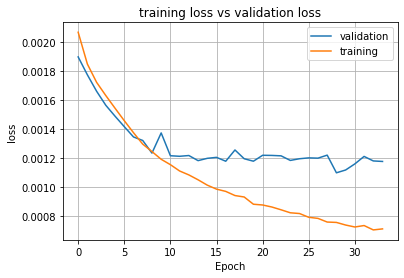

In [90]:
val_line, = plt.plot(valid_losses, label='validation')
train_line, =plt.plot(train_losses, label='training')
plt.legend(handles=[val_line, train_line])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.title("training loss vs validation loss")


In [91]:
total_predictions = total_predictions.cpu()
total_predictions.argmax(dim=1).shape

torch.Size([900])

In [92]:
total_labels = torch.tensor(ins_dataset_test.df['class'])
total_labels.shape

torch.Size([900])

Confusion matrix

In [93]:
cm = confusion_matrix(total_labels, total_predictions.argmax(dim=1))
cm

array([[61,  3,  3, 15,  0,  0,  2,  1,  1,  1],
       [ 1, 52,  2,  5,  0,  0,  2,  1,  2, 13],
       [ 4,  2, 52,  3,  4,  3,  1,  5,  1,  2],
       [ 9,  3,  1, 74,  4,  0,  1,  2,  3,  0],
       [ 0,  6,  9,  0, 60,  4,  1,  1, 11,  3],
       [ 1,  6,  3,  3, 11, 49, 11,  0,  4,  5],
       [ 3,  2,  4,  8,  9, 22, 37,  7, 11,  3],
       [ 3,  9,  3,  9,  0, 13,  5, 33, 10,  1],
       [ 0,  5,  3,  4,  6,  9,  5,  5, 58,  4],
       [ 0,  7,  0,  2,  1,  0,  0,  0,  1, 71]])

easy viewing

In [0]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


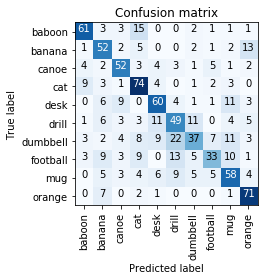

In [95]:
plot_confusion_matrix(cm, class_names)